# Mining Process – % Silica Concentrate Prediction

This project aims to develop a **machine learning regression model** to predict the **% Silica Concentrate** in a mining flotation process using operational plant data.  
Accurate prediction of silica concentration is essential to improve process efficiency, reduce laboratory dependency, and support real-time decision-making in the field. The code is divided into three main parts, which are:
1. Data ingestion and preprocessing  
2. Feature selection and treatment  
3. Time-aware train-test split  
4. Model training with early stopping  
5. Performance evaluation and result visualization  


**Responsible:** Paulo Casmal

**Email:** <paulo.casmal@gmail.com>

**Date:** 12-15-2025


---


## 01 - Imports & Configurations

In [168]:
# import necessary libraries
import pandas as pd
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [169]:
# Configuration of matplotlib parameters for consistent styling
mpl.rcParams['figure.figsize'] = (10, 6)  # Default figure size
mpl.rc('lines', lw=2)  # Sets the line width
mpl.rcParams['grid.linewidth'] = 0.5  # Grid line width
mpl.rcParams['grid.linestyle'] = 'dashed'  # Grid line style
mpl.rc(('xtick', 'ytick'), labelsize=15)  # Axis tick label size
mpl.rc('font', family='Century Gothic', size=15)  # Font family and font size
mpl.rcParams['axes.linewidth'] = 0.5 # - Largura das bordas dos gráficos

In [170]:
# Load the dataset
path = r'C:\Users\paulo\Downloads\archive (2)\MiningProcess_Flotation_Plant_Database.csv'

df = pd.read_csv(path, decimal=',')

df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


## 02 - Dataset treatment

In [171]:
# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [172]:
df.columns

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

Drop the '% Iron Concentrate' column due to high correlation with target variable. Additionaly, this variable can be measured only at laboratory, which not helps to predict the '% Silica Concentrate' in field.

In [173]:
df = df.drop(columns=['% Iron Concentrate'])

### 2.1 - Resampling

In [174]:
df_hourly = df.resample("1H").mean()

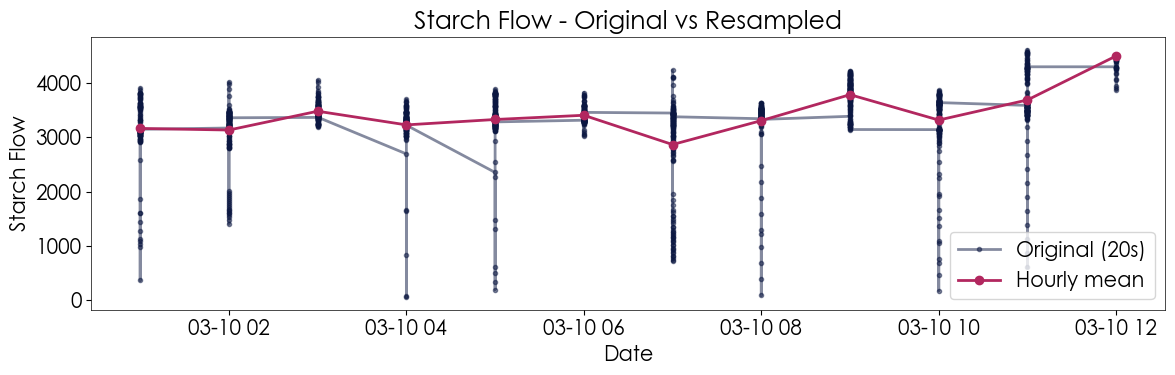

In [175]:
col = "Starch Flow" 

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df[col].iloc[:2000], label="Original (20s)", alpha=0.5, marker='.', c='#0B1741')
ax.plot(df_hourly[col].iloc[:12], label="Hourly mean", marker='o', c='#B2275F')

ax.set_title(f'{col} - Original vs Resampled')
ax.set_xlabel('Date')
ax.set_ylabel(f'{col}')
ax.legend()

plt.tight_layout()

fig.savefig(r'G:\Meu Drive\03 - Facens\03 - Data Science\02-TCC-POS\05-Figures\ds-resampled.svg', dpi=140, format='svg')

plt.show()


In [176]:
df = df.resample("1H").mean()

### 2.2 - Adding Time Features

In [177]:


def create_time_features(df):
    """Create time-based features from datetime index."""
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter

    return df


df = create_time_features(df)

### 2.3 - Cross-Validation

In [178]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*14, gap=24) # 15 days data for testing

df = df.sort_index()

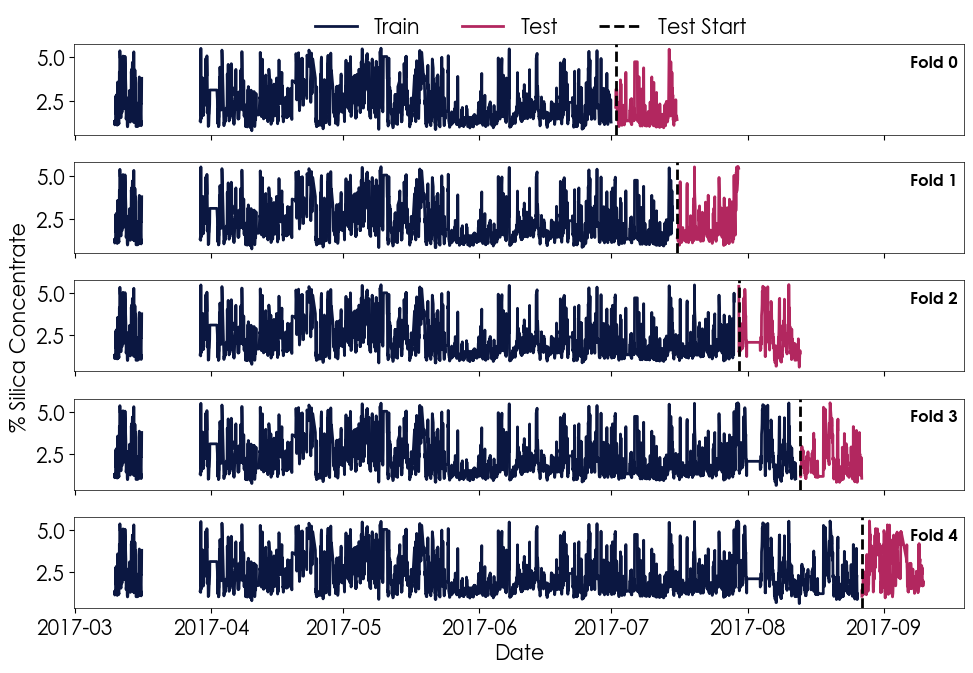

In [179]:
# Just for vizualization purposes
fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)

# Plot each fold
for fold, (train_index, test_index) in enumerate(tss.split(df)):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    axs[fold].plot(train.index, train['% Silica Concentrate'], label='Train', c='#0B1741')
    axs[fold].plot(test.index, test['% Silica Concentrate'], label='Test', c='#B2275F')
    axs[fold].axvline(x=test.index[0], color='k', linestyle='--', label='Test Start')

    axs[fold].text(0.94, 0.75, f'Fold {fold}', fontsize=12, transform=axs[fold].transAxes, fontweight='bold')


axs[2].set_ylabel('% Silica Concentrate')

axs[0].legend(ncol=3, loc='upper left', bbox_to_anchor=(0.25, 1.5), frameon=False)

plt.xlabel('Date')
plt.tight_layout()

fig.savefig(r'G:\Meu Drive\03 - Facens\03 - Data Science\02-TCC-POS\05-Figures\time-series-split.svg', dpi=140, format='svg', transparent=True)

plt.show()

### 2.4 - StandardScaler

In [184]:
df = df.dropna()

In [185]:
X_train = df.drop(columns=['% Silica Concentrate'])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

### 2.5 - Principal Components Analysis

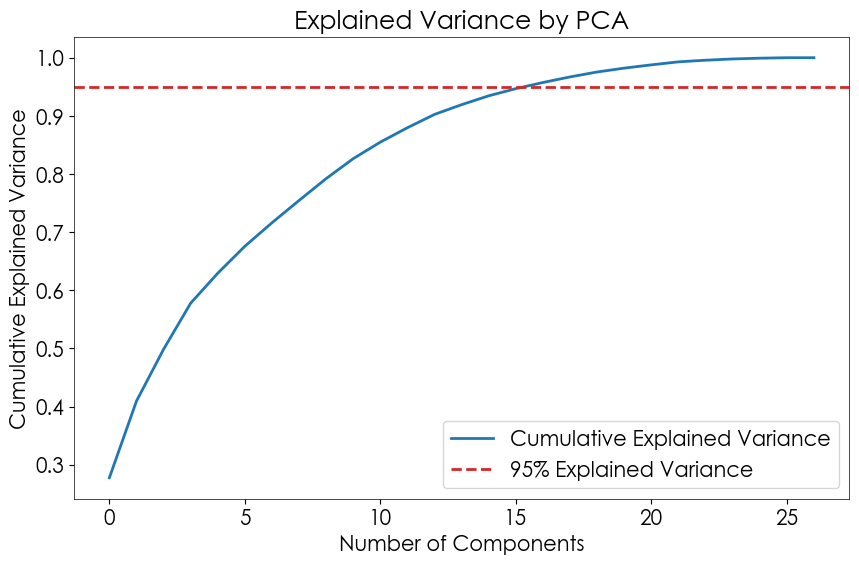

In [186]:
pca = PCA().fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Explained Variance', c='tab:blue')
plt.axhline(0.95, linestyle='--', c='tab:red', label='95% Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA')
plt.legend(loc=4)

plt.show()

## 03 - Applying XGBoost Model

In [ ]:
scores = []
r2s = []
maes = []

for fold, (train_index, test_index) in enumerate(tss.split(df)):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    X = train.drop(columns=['% Silica Concentrate'])
    y = train['% Silica Concentrate']

    X_test = test.drop(columns=['% Silica Concentrate'])
    y_test = test['% Silica Concentrate']

    # Split temporal interno (validação)
    split_idx = int(len(X) * 0.8)

    X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=4,
        random_state=42,
        verbose=100
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    scores.append(rmse)
    r2s.append(r2)
    maes.append(mae)

    print(
        f'Fold {fold} | '
        f'RMSE: {rmse:.4f} | '
        f'R²: {r2:.4f} | '
        f'MAE: {mae:.4f}'
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 1000
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 2 of 1000
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
building tree 3 of 1000
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
building tree 4 of 1000
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
building tree 5 of 1000
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
building tree 6 of 1000
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
building tree 7 of 1000
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
building tree 8 of 1000
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
building tree 9 of 1000
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s re

## 04 - Result Analysis

In [189]:
print(f'Average RMSE across folds: {np.mean(scores)}')
print(f'RMSE scores for each fold: {scores}')

Average RMSE across folds: 1.0691083030693889
RMSE scores for each fold: [1.0286664007582436, 1.0820148437928303, 1.023459303636433, 0.9738878915292754, 1.237513075630161]


In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(train_rmse, label='Train RMSE')
# plt.plot(val_rmse, label='Validation RMSE')
# plt.xlabel('Iteration')
# plt.ylabel('RMSE')
# plt.title('XGBoost Training vs Validation')
# plt.legend()

# # plt.yscale('log')
# plt.grid(True)
# plt.show()

NameError: name 'train_rmse' is not defined

<Figure size 1000x600 with 0 Axes>

In [192]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.3f}')
print(f'R^2 Score: {r2:.3f}')

Mean Absolute Error: 0.954
R^2 Score: -0.063


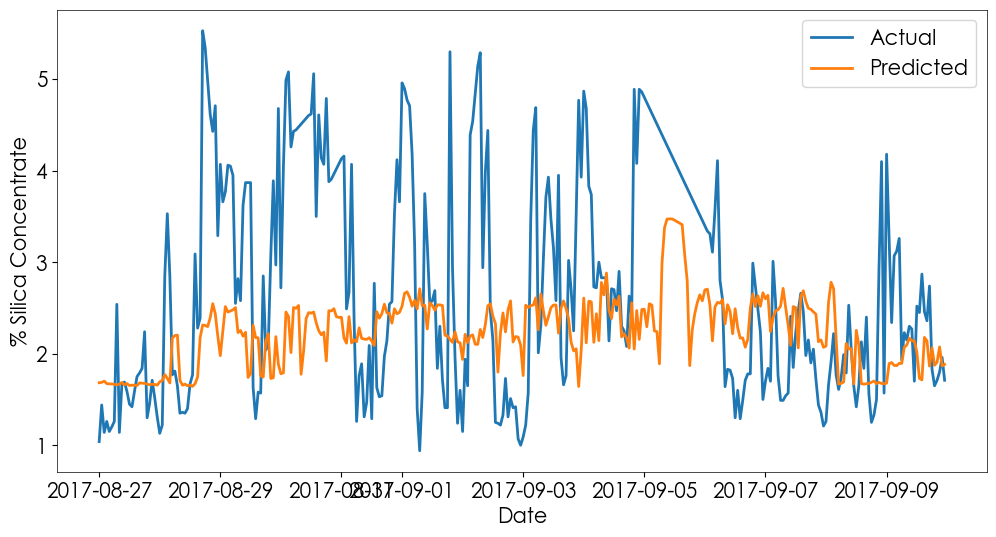

In [193]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label='Actual', c='tab:blue')
plt.plot(y_test.index, y_pred, label='Predicted', c='tab:orange')   

plt.ylabel('% Silica Concentrate')
plt.xlabel('Date')
plt.legend(loc='upper right')

plt.show()